In [1]:
#basic imports
import numpy as np
import pandas as pd
import transformers
import datasets
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import wandb
import os

# Force terminate any existing runs
try:
    wandb.finish()
except:
    pass

# Clear any wandb processes
os.system('wandb docker-run --clean')

# Now login with your API key
os.environ["WANDB_API_KEY"] = "d26dd1d7dea66bdf56b52f3745f3f3c747c32fa5"  # Replace with your key from wandb.ai/settings

### adjusting dataset paramters

In [3]:
from datasets import load_dataset
ds = load_dataset('tdavidson/hate_speech_offensive')

README.md:   0%|          | 0.00/5.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

In [4]:
ds = ds['train'].train_test_split(train_size=0.85)

In [5]:
ds = ds.remove_columns(['count','hate_speech_count','offensive_language_count','neither_count'])

In [6]:
ds = ds.rename_column('tweet','text')
ds = ds.rename_column('class','label')

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 21065
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 3718
    })
})

### exploring dataset

In [8]:
ds.set_format("pandas")

In [9]:
df = ds['train'][:]

In [10]:
df

label                                               text
0          2  Paceys just told me about how flash was touchi...
1          2  Tonight. My sole purpose is to be thoroughly i...
2          1  RT @_tonktrippin: if you can't do or say certa...
3          1  @iLLEGALLYBadd my boy said this last night. I'...
4          1      Dumb little broad , move the fuck along bitch
...      ...                                                ...
21060      1  @todd_calfee @WdmJeff Hell - was lucky to have...
21061      1  cant stand when a nicca pillow talk about you ...
21062      0  @salomanizor I'm a faggot :/\n\nhttp://t.co/Gr...
21063      2  @ramaxe1965 dubya hates todays teabagger movem...
21064      2  Shylock &amp; Wongs: 3 Incidents of Democrat B...

[21065 rows x 2 columns]

In [11]:
#0 -> neither 1->offensive 2- >neither
df['label'].value_counts()

label
1    16273
2     3546
0     1246
Name: count, dtype: int64

In [12]:
def int2str_label(row):
    return ds['train'].features['label'].int2str(row)

In [13]:
df['type'] = df['label'].apply(int2str_label)

### very imbalanced dataset

<Axes: xlabel='type', ylabel='count'>

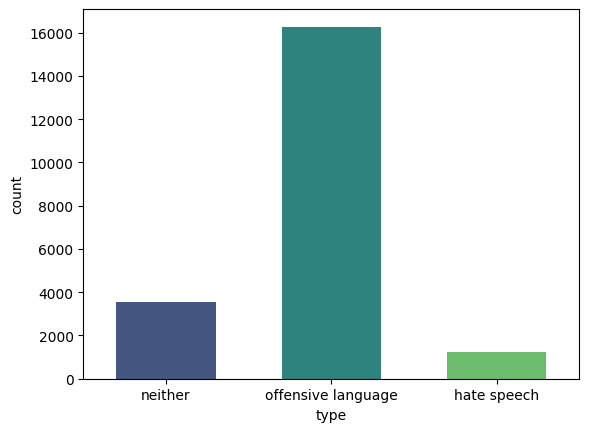

In [14]:
sns.countplot(x='type',data=df,width=0.6,palette='viridis')

In [15]:
#wrd len per class
df['wrd_len'] = df['text'].str.split().apply(len)

<Axes: ylabel='wrd_len'>

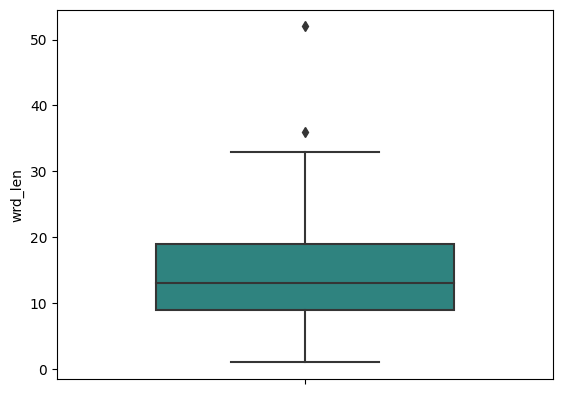

In [16]:
sns.boxplot(y='wrd_len',data=df,width=0.6,palette='viridis',hue='type')

### load tokenizer

In [17]:
from transformers import AutoTokenizer
bert_path = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(bert_path)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
tokenizer("sample text for testing")

{'input_ids': [101, 7099, 3793, 2005, 5604, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

### reset format

In [19]:
ds.reset_format()
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 21065
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 3718
    })
})

### apply tokenizer to the dataset

In [20]:
def apply_tokenizer(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [21]:
ds = ds.map(apply_tokenizer,batched=True,batch_size=None)

Map:   0%|          | 0/21065 [00:00<?, ? examples/s]

Map:   0%|          | 0/3718 [00:00<?, ? examples/s]

In [22]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21065
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3718
    })
})

### convert to PT tensors 

In [23]:
ds.set_format("pt",columns=['input_ids','attention_mask','label'])

In [24]:
ds['train'][0]

{'label': tensor(2),
 'input_ids': tensor([  101,  6393,  7274,  2074,  2409,  2033,  2055,  2129,  5956,  2001,
          7244,  2370,  1998,  2002,  2001,  3810,  3756,  1998,  2304,  1012,
          1012,  1001,  2054, 27283, 28765,  2290,  1004,  1001, 11899, 22203,
          2549,  1025,  1004,  1001, 11899, 22203,  2549,  1025,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

### load model

In [25]:
from transformers import AutoModelForSequenceClassification
import torch
device = torch.device("cuda")
num_labels = 3
model = (AutoModelForSequenceClassification.from_pretrained(bert_path,num_labels=num_labels).to(device))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### compute metrics

In [27]:
from sklearn.metrics import f1_score,accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'f1':f1,'acc':acc}

### training arguments

In [28]:
from transformers import TrainingArguments
model_name = 'bert-hate-speech-detection'
batch_size = 32
weight_decay = 0.01
num_train_epochs = 2
learning_rate = 2e-5
logging_steps = len(ds['train'])//batch_size
training_args = TrainingArguments(output_dir=model_name,
                                 per_device_eval_batch_size=batch_size,
                                 per_device_train_batch_size=batch_size,
                                 weight_decay=weight_decay,
                                 num_train_epochs=num_train_epochs,
                                 learning_rate=learning_rate,
                                 log_level="error",
                                 eval_strategy="epoch",
                                 disable_tqdm=False,
                                 push_to_hub=False,
                                 logging_steps=logging_steps)

### trainer

In [29]:
from transformers import Trainer
trainer = Trainer(model,
                 args = training_args,
                 compute_metrics=compute_metrics,
                 train_dataset=ds['train'],
                 eval_dataset=ds['test'])

In [30]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adi-joshi2018 (adi-joshi2018-vit). Use `wandb login --relogin` to force relogin


TrainOutput(global_step=1318, training_loss=0.25956271817181287, metrics={'train_runtime': 2209.3705, 'train_samples_per_second': 19.069, 'train_steps_per_second': 0.597, 'total_flos': 1.041380809951482e+16, 'train_loss': 0.25956271817181287, 'epoch': 2.0})